In [1]:
import tensorflow as tf
import numpy as np
import data
import matplotlib.pyplot as plt

%matplotlib inline

Reading files: 08527   
Reading successful!


In [25]:
a = [30, 30, 30]

TypeError: str() argument 2 must be str, not int

In [2]:
num_epochs = 10
batch_size = 4
time_steps = 250
input_dims = 1

train_steps = 3

hidden_rnn_sizes = [30, 30, 30]
hidden_fc_sizes = [40, 30]
output_dims = 1

data_feed = data.batch_pool(batch_size, num_epochs)

# LSTM definition

In [3]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [batch_size, None, input_dims])
seq_len = tf.placeholder(tf.int16, [None])

''' FIXED HIDDEN STATE SIZE
init_state = np.zeros((num_layers, 2, batch_size, hidden_state_size))
state_placeholder = tf.placeholder(tf.float32, [num_layers, 2, None, hidden_state_size])
l = tf.unstack(state_placeholder, axis=0)
rnn_tuple_state = tuple(
    [tf.contrib.rnn.LSTMStateTuple(l[idx][0], l[idx][1])
     for idx in range(num_layers)]
    )
'''

rnn_tuple_state = []
for size in hidden_rnn_sizes:
    shape = [2, batch_size, size]
    ph = tf.placeholder(tf.float32, shape)
    rnn_tuple_state.append(
        tf.contrib.rnn.LSTMStateTuple(ph[0], ph[1]))
rnn_tuple_state = tuple(rnn_tuple_state)    


    
'lstm_cell = tf.contrib.rnn.BasicLSTMCell(hidden_state_size, forget_bias=1.)'
cells = [tf.contrib.rnn.BasicLSTMCell(size) for size in hidden_rnn_sizes]
multi_cell = tf.contrib.rnn.MultiRNNCell(cells)

outputs, last_states = tf.nn.dynamic_rnn(
    initial_state=rnn_tuple_state,
    inputs=x, cell=multi_cell, 
    sequence_length=seq_len)

''' 
    Does not give back the true last, may be 0
    last_output = output[:, -1]
'''

last_output = last_states[-1][1]
#act_fn = tf.tanh
act_fn = tf.nn.relu
# Classification
# h = last_output
# Generation
h = outputs
for size in hidden_fc_sizes:
    h = tf.contrib.layers.fully_connected(h, size, act_fn)
preds = tf.contrib.layers.fully_connected(h, output_dims, None)

In [4]:
target = tf.placeholder(tf.float32, [batch_size, None, output_dims])
loss = tf.reduce_sum((preds-target)**2)
opt = tf.train.AdamOptimizer().minimize(loss)

In [5]:
preds

<tf.Tensor 'fully_connected_2/Reshape_1:0' shape=(4, ?, 1) dtype=float32>

In [7]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    losses = []
    predictions = []
    i = 0
    for batch in data_feed:
        i += 1
        s = sess.run(multi_cell.zero_state(batch_size, tf.float32))
        x_feed, y_feed, lens_feed = batch
        # Generator
        y_feed = np.roll(x_feed, 1)
        for idx in range(0, lens_feed.max(), time_steps):
            if idx%500 == 0:
                print('\r%d'%idx, end='', flush=True)
            data_window = x_feed[:, idx:idx+time_steps]
            target_window = y_feed[:, idx:idx+time_steps]
            lens_window = lens_feed-idx
            feed_dict = {
                x:data_window,
                rnn_tuple_state:s,
                seq_len:lens_window,
                target:target_window
            }
            _, p, l, s = sess.run([opt, preds, loss, last_states], feed_dict)
            predictions.append(p.squeeze())
            losses.append(l)
        print('\n')
        if i > 30: break
        
        
    

8500

9500

8500

8500

17500

17500

17500

8500

17500

8500

13000

17500

17500

8500

8500

17500

8500

8500

17500

17500

17500

9500

11500

17500

9000

17500

17500

17500

8500

8500

9500



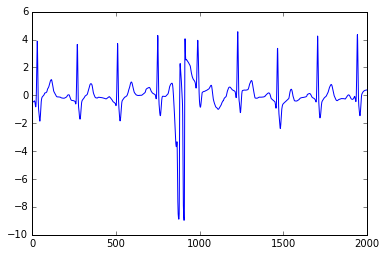

In [16]:
p = np.concatenate(predictions, axis=1)

plt.plot(p[2, -2000:].T)
#predictions[0].shape

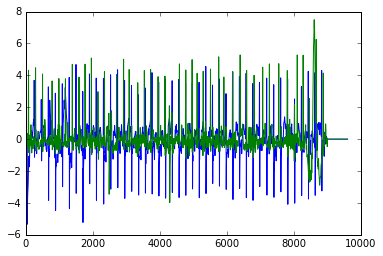

In [16]:
plt.plot(x_feed[:2].squeeze().T)
#data_window.shape

In [47]:
x_feed = batch[0]
x_feed[0]-x_feed[3]

array([ 0.61605638,  0.71292919,  0.80252498, ...,  0.13209474,
        0.14843857,  0.16830629], dtype=float32)

In [14]:
len(losses)

72

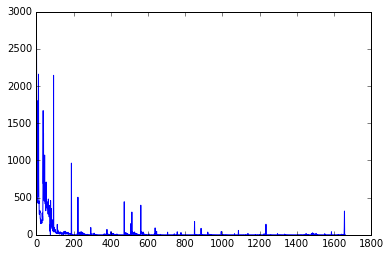

In [21]:
plt.plot(losses)
tf.get_default_graph()
tf.summary.FileWriter()

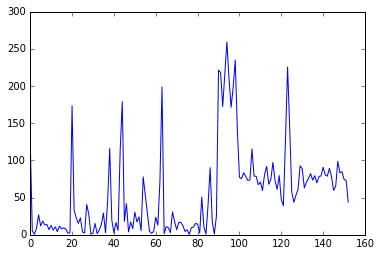

In [11]:
plt.plot(losses)

In [13]:
for batch in data_feed:
    data, label, lens = batch
    break
data    

array([array([-223, -268, -311, ...,   33,   31,   30], dtype=int16),
       array([-264, -254, -231, ...,   84,   89,   90], dtype=int16),
       array([14, 15, 16, ..., 18, 18, 18], dtype=int16),
       array([31, 55, 70, ..., 16, 14, 12], dtype=int16),
       array([102, 126, 152, ..., -70, -52, -38], dtype=int16),
       array([146, 185, 224, ...,  -6,  11,  25], dtype=int16),
       array([ 162,  194,  229, ..., -302, -261, -157], dtype=int16)], dtype=object)

In [9]:
%debug

> <ipython-input-8-6ecb33e47eb3>(22)<module>()
     20             l, s = sess.run([preds, last_states], feed_dict)
     21             losses.append(l)
---> 22         if i > 3: break
     23 
     24 

ipdb> data
array([array([-127, -162, -197, ...,  -18,  -22,  -21], dtype=int16)], dtype=object)
ipdb> exit


# Misc

In [9]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, time_steps, input_dims])
seq_len = tf.placeholder(tf.int16, [None])

''' FIXED HIDDEN STATE SIZE
init_state = np.zeros((num_layers, 2, batch_size, hidden_state_size))
state_placeholder = tf.placeholder(tf.float32, [num_layers, 2, None, hidden_state_size])
l = tf.unstack(state_placeholder, axis=0)
rnn_tuple_state = tuple(
    [tf.contrib.rnn.LSTMStateTuple(l[idx][0], l[idx][1])
     for idx in range(num_layers)]
)
'''

rnn_tuple_state = []
for size in hidden_rnn_sizes:
    shape = [2, batch_size, size]
    ph = tf.placeholder(tf.float32, shape)
    rnn_tuple_state.append(
        tf.contrib.rnn.LSTMStateTuple(ph[0], ph[1]))
rnn_tuple_state = tuple(rnn_tuple_state)    


    
'lstm_cell = tf.contrib.rnn.BasicLSTMCell(hidden_state_size, forget_bias=1.)'
cells = [tf.contrib.rnn.BasicLSTMCell(size) for size in hidden_rnn_sizes]
multi_cell = tf.contrib.rnn.MultiRNNCell(cells)

outputs, last_states = tf.nn.dynamic_rnn(
    initial_state=rnn_tuple_state,
    inputs=x, cell=multi_cell, 
    sequence_length=seq_len)

''' 
    Does not give back the true last, may be 0
    last_output = output[:, -1]
'''

last_output = last_states[-1][1]
act_fn = tf.tanh
preds = tf.contrib.layers.fully_connected(outputs, pred_size, act_fn)

In [10]:
preds

<tf.Tensor 'fully_connected/Tanh:0' shape=(64, 15, 1) dtype=float32>

In [12]:

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    s = sess.run(multi_cell.zero_state(batch_size, tf.float32))
    for i in range(train_steps):
        feed_dict = {
            x:np.ones([batch_size, time_steps, input_dims]),
            rnn_tuple_state:s,
            seq_len:np.ones(batch_size) * time_steps+1
        }
        
        #s = sess.run([last_states], feed_dict)
        
        p, s = sess.run([preds, last_states], feed_dict)
        
    

In [13]:
s

(LSTMStateTuple(c=array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32), h=array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)),
 LSTMStateTuple(c=array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32), h=array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 

In [56]:
preds

<tf.Tensor 'fully_connected_1/Reshape_1:0' shape=(64, 15, 1) dtype=float32>

# Miscallenous

In [7]:
num_epochs = 10
batch_size = 64
time_steps = 15
input_dims = 1

num_layers = 3
hidden_state_size = 10

In [34]:
batch_size = 3
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, time_steps, input_dims])
seq_len = tf.placeholder(tf.int16, [None])

''' FIXED HIDDEN STATE SIZE
init_state = np.zeros((num_layers, 2, batch_size, hidden_state_size))
state_placeholder = tf.placeholder(tf.float32, [num_layers, 2, None, hidden_state_size])
l = tf.unstack(state_placeholder, axis=0)
rnn_tuple_state = tuple(
    [tf.contrib.rnn.LSTMStateTuple(l[idx][0], l[idx][1])
     for idx in range(num_layers)]
)
'''

hidden_rnn_sizes = [6, 5, 4]
rnn_tuple_state = []
for size in hidden_rnn_sizes:
    shape = [2, batch_size, size]
    ph = tf.placeholder(tf.float32, shape)
    rnn_tuple_state.append(
        tf.contrib.rnn.LSTMStateTuple(ph[0], ph[1]))
rnn_tuple_state = tuple(rnn_tuple_state)    


    
'lstm_cell = tf.contrib.rnn.BasicLSTMCell(hidden_state_size, forget_bias=1.)'
cells = [tf.contrib.rnn.BasicLSTMCell(size) for size in hidden_rnn_sizes]
multi_cell = tf.contrib.rnn.MultiRNNCell(cells)

output, last_state = tf.nn.dynamic_rnn(
    initial_state=rnn_tuple_state,
    inputs=x, cell=multi_cell, 
    sequence_length=seq_len)

''' 
    Does not give back the true last, may be 0
    last_output = output[:, -1]
'''

last_output = last_state[-1][1]

In [39]:
init_state

(LSTMStateTuple(c=array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32), h=array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)),
 LSTMStateTuple(c=array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]], dtype=float32), h=array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]], dtype=float32)),
 LSTMStateTuple(c=array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]], dtype=float32), h=array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]], dtype=float32)))

In [49]:
with tf.Session() as sess:
    s = sess.run(multi_cell.zero_state(batch_size, tf.float32))
    feed_dict = {
        x:np.ones([batch_size, time_steps, input_dims]),
        rnn_tuple_state:s,
        seq_len:[2, 6, 2]
    }
    
    tf.global_variables_initializer().run()
    o, l, s = sess.run([output, last_output, last_state], feed_dict)
    

In [49]:
with tf.Session() as sess:
    s = sess.run(multi_cell.zero_state(batch_size, tf.float32))
    feed_dict = {
        x:np.ones([batch_size, time_steps, input_dims]),
        rnn_tuple_state:s,
        seq_len:[2, 6, 2]
    }
    
    tf.global_variables_initializer().run()
    o, l, s = sess.run([output, last_output, last_state], feed_dict)
    

In [41]:
o

array([[[ 0.00414114, -0.00117444, -0.00061634,  0.00149639],
        [ 0.01358755, -0.00358437, -0.00219923,  0.00502674],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.00414114, -0.00117444, -0.00061634,  0.00149639],
      

In [42]:
l

array([[ 0.01358755, -0.00358437, -0.00219923,  0.00502674],
       [ 0.08272725, -0.01660139, -0.01948575,  0.03442191],
       [ 0.01358755, -0.00358437, -0.00219923,  0.00502674]], dtype=float32)

In [ ]:
with tf.Session() as sess:
    s = sess.run(multi_cell.zero_state(batch_size, tf.float32))
    feed_dict = {
        x:np.ones([batch_size, time_steps, input_dims]),
        rnn_tuple_state:s,
        seq_len:[2, 6, 2]
    }
    
    tf.global_variables_initializer().run()
    o, l, s = sess.run([output, last_output, last_state], feed_dict)
    

In [1]:
import genmodel
g = genmodel.generator